In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


In [3]:
num_examples = 5
for i in range(num_examples):
    example = train_data[i]
    label_index = train_labels[i]
    label_name = newsgroups_train.target_names[label_index]
    
    print '***** BEGIN EXAMPLE ' + str(i) + ' *****'
    print 'Training label: ' + str(label_index) + ' (' + label_name + ')'
    print 'Text:'
    print '-----'
    
    print ''
    print example
    print ''
    print '***** END EXAMPLE ' + str(i) + ' *****'
    print ''


***** BEGIN EXAMPLE 0 *****
Training label: 1 (comp.graphics)
Text:
-----

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

***** END EXAMPLE 0 *****

***** BEGIN EXAMPLE 1 *****
Training label: 3 (talk.religion.misc)
Text:
-----



Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional 

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [297]:
#def P2():
### STUDENT START ###

def vectorize(data):
    vectorizer = CountVectorizer()
    vectorizer.fit(data)
    return vectorizer

def select_nonzero_indices(example):
    return example.nonzero()[1]

def select_features_by_indices(feature_names, indices):
    features = [
        feature_name
        for index, feature_name
        in enumerate(feature_names)
        if index in indices
    ]
    return features

def select_features_from_example(example, feature_names):
    indices = select_nonzero_indices(example)
    return select_features_by_indices(feature_names, indices)

def select_non_zero_vector(examples):
    (rows, columns) = np.shape(examples)
    nnz_vector = [
        examples[index].nnz
        for index
        in range(rows)
    ]
    
    return nnz_vector

def slice_by_columns(csr_matrix, column_indices):
    csc_matrix = csr_matrix.tocsc()
    csc_sliced = csc_matrix[:, column_indices]
    return csc_sliced.tocsr()

def P2():
    
    def P2a():
        vectorizer = vectorize(train_data)
        train_vectorized = vectorizer.transform(train_data)

        (examples, features) = np.shape(train_vectorized)
        non_zero_total = train_vectorized.nnz
        non_zero_vector = select_non_zero_vector(train_vectorized)
        feature_names = vectorizer.get_feature_names()

        print '***** (2) a. Output of the transform *****'
        print ''
        print '  Size of the vocabulary: ' + str(features)
        print '  Average non-zero features: ' + str(np.mean(non_zero_vector))
        print '  Non-zero fraction: ' + str((non_zero_total * 1.0) / (examples * features * 1.0))
        print ''
        
        return (vectorizer, train_vectorized, feature_names)
    
    (vectorizer, train_vectorized, feature_names) = P2a()
    
    def P2b(vectorizer, train_vectorized, feature_names):
        (examples, features) = np.shape(train_vectorized)
        zeroeth_example = train_vectorized[0]
        last_example = train_vectorized[examples - 1]
        next_to_last_example = train_vectorized[examples - 2]

        zeroeth_features = select_features_from_example(zeroeth_example, feature_names)
        last_features = select_features_from_example(last_example, feature_names)
        next_to_last_features = select_features_from_example(next_to_last_example, feature_names)


        print '***** (2) b. 0th and last feature strings *****'
        print ''
        print '  0th feature string: '
        print '    ' + ' '.join(zeroeth_features)
        print '  last feature string: '
        print '    ' + ' '.join(last_features)
        print '  next to last feature string (last is empty): '
        print '    ' + ' '.join(next_to_last_features)
        print ''
        
    P2b(vectorizer, train_vectorized, feature_names)
    
    def P2c(feature_names):
        four_word_vocabulary = [ 'atheism', 'graphics', 'space', 'religion' ]
        four_word_indices = [
            index
            for index, feature_name
            in enumerate(feature_names)
            if feature_name in four_word_vocabulary
        ]

        four_word_train_vectorized = slice_by_columns(train_vectorized, four_word_indices)
        four_word_non_zero_vector = select_non_zero_vector(four_word_train_vectorized)


        print '***** (2) c. 4 word vocabulary *****'
        print ''

        print '  Shape of four-word vocabulary vectored training data: ' + \
            str(np.shape(four_word_train_vectorized))
        print '  Average non-zero: ' + str(np.mean(four_word_non_zero_vector))
        print ''
    
    P2c(feature_names)
    
    def P2d():
        def vectorize_as_character_bigrams_trigrams(data):
            vectorizer = CountVectorizer(analyzer = 'char_wb', ngram_range = (2, 3))
            vectorizer.fit(data)
            return vectorizer

        vectorizer = vectorize_as_character_bigrams_trigrams(train_data)
        train_char_bigram_trigram_vectorized = vectorizer.transform(train_data)
        (examples, features) = np.shape(train_char_bigram_trigram_vectorized)

        print '***** (2) d. bigram/trigram character features vocabulary *****'
        print ''
        print '  Number of features (word-boundary character bigram/trigram): ' + str(features)
        print ''
    
    P2d()
    
    def P2e():
        def vectorize_with_document_frequency_pruning(data, min_df = 10):
            vectorizer = CountVectorizer(min_df = min_df)
            vectorizer.fit(data)
            return vectorizer

        vectorizer = vectorize_with_document_frequency_pruning(train_data, 10)
        train_vectorized_pruned_min_df_10 = vectorizer.transform(train_data)
        (examples, features) = np.shape(train_vectorized_pruned_min_df_10)

        print '***** (2) e. mininum document frequency 10 vocabulary *****'
        print ''
        print '  Number of features (word-boundary character bigram/trigram): ' + str(features)
        print ''
    
    P2e()
    
    def P2f():
        train_feature_names = vectorize(train_data).get_feature_names()
        dev_feature_names = vectorize(dev_data).get_feature_names()
        feature_names_intersection = set(train_feature_names).intersection(dev_feature_names)

        missing_fraction = 1.0 - ((1.0 * len(feature_names_intersection)) / (1.0 * len(dev_feature_names)))

        print '***** (2) f. fraction of missing dev vocabulary *****'
        print ''
        print '  Fraction of missing dev features from train vocabulary: ' + str(missing_fraction)
        print ''
        
    P2f()
    
    
P2()

### STUDENT END ###
#P2()

***** (2) a. Output of the transform *****

  Size of the vocabulary: 26879
  Average non-zero features: 96.7059980334
  Non-zero fraction: 0.00359782722696

***** (2) b. 0th and last feature strings *****

  0th feature string: 
    3ds able about after all and anyone are available be but carefully cel default does explicitly file for format from given have hi if in information is it know like manual mapping model not nothing noticed only orientation planes position positioned positions preserved prj read reload restarting rule rules rych said save saving somewhere stored texture that the their they this to ve when why with you your
  last feature string: 
    
  next to last feature string (last is empty): 
    _anything_ _behaviors_ _knowledgeable _waving about again all an and any application aquainted around as assertion atheism because becomes becoming being belief believe believer believer_ bit blah by call can carelessly caste certain circular coming contradiction conversely de

In [138]:




four_word_vocabulary = [ 'atheism', 'graphics', 'space', 'religion' ]
four_word_indices = [
    index
    for index, feature_name
    in enumerate(feature_names)
    if feature_name in four_word_vocabulary
]

four_word_train_vectorized = slice_by_columns(train_vectorized, four_word_indices)
four_word_non_zero_vector = select_non_zero_vector(four_word_train_vectorized)


print '***** (2) c. 4 word vocabulary *****'
print ''

print '  Shape of four-word vocabulary vectored training data: ' + \
    str(np.shape(four_word_train_vectorized))
print '  Average non-zero: ' + str(np.mean(four_word_non_zero_vector))
print ''



***** (2) c. 4 word vocabulary *****

  Shape of four-word vocabulary vectored training data: (2034, 4)
  Average non-zero: 0.268436578171



In [144]:
def vectorize_as_character_bigrams_trigrams(data):
    vectorizer = CountVectorizer(analyzer = 'char_wb', ngram_range = (2, 3))
    vectorizer.fit(data)
    return vectorizer

vectorizer = vectorize_as_character_bigrams_trigrams(train_data)
train_char_bigram_trigram_vectorized = vectorizer.transform(train_data)
(examples, features) = np.shape(train_char_bigram_trigram_vectorized)

print '***** (2) d. bigram/trigram character features vocabulary *****'
print ''
print '  Number of features (word-boundary character bigram/trigram): ' + str(features)
print ''

***** (2) d. bigram/trigram character features vocabulary *****

  Number of features (word-boundary character bigram/trigram): 28954



In [145]:
def vectorize_with_document_frequency_pruning(data, min_df = 10):
    vectorizer = CountVectorizer(min_df = min_df)
    vectorizer.fit(data)
    return vectorizer

vectorizer = vectorize_with_document_frequency_pruning(train_data, 10)
train_vectorized_pruned_min_df_10 = vectorizer.transform(train_data)
(examples, features) = np.shape(train_vectorized_pruned_min_df_10)

print '***** (2) e. mininum document frequency 10 vocabulary *****'
print ''
print '  Number of features (word-boundary character bigram/trigram): ' + str(features)
print ''

***** (2) e. mininum document frequency 10 vocabulary *****

  Number of features (word-boundary character bigram/trigram): 3064



In [154]:
train_feature_names = vectorize(train_data).get_feature_names()
dev_feature_names = vectorize(dev_data).get_feature_names()
feature_names_intersection = set(train_feature_names).intersection(dev_feature_names)

missing_fraction = 1.0 - ((1.0 * len(feature_names_intersection)) / (1.0 * len(dev_feature_names)))

print '***** (2) f. fraction of missing dev vocabulary *****'
print ''
print '  Fraction of missing dev features from train vocabulary: ' + str(missing_fraction)
print ''

len(dev_feature_names)


***** (2) f. fraction of missing dev vocabulary *****

  Fraction of missing dev features from train vocabulary: 0.247876400345



16246

In [215]:
from sklearn.metrics.pairwise import pairwise_distances

vectorizer = vectorize(train_data)
train_vectorized = vectorizer.transform(train_data)
dev_vectorized = vectorizer.transform(dev_data)

def best_nearest_neighbors(train_vectorized, train_labels, n_neighbors = range(1, 10)):
    
    hyperparameters = { 'n_neighbors' : n_neighbors } 
    nearest_neighbors = KNeighborsClassifier()
    
    grid_search = GridSearchCV(nearest_neighbors, hyperparameters, verbose = 1, scoring = 'f1')
    grid_search.fit(train_vectorized, train_labels)
    
    return grid_search.best_estimator_

nearest_neighbors = best_nearest_neighbors(train_vectorized, train_labels)

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    2.0s finished


Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [216]:
best_n_neighbors = nearest_neighbors.get_params()['n_neighbors']
dev_predictions = nearest_neighbors.predict(dev_vectorized)
knn_f1_score = metrics.f1_score(dev_labels, dev_predictions)

print '***** (3) a. k nearest neighbors *****'
print ''
print '  Best k: ' + str(best_n_neighbors)
print '  F1 score over dev data: ' + str(knn_f1_score)
print ''

***** (3) a. k nearest neighbors *****

  Best k: 9
  F1 score over dev data: 0.43656661762



In [181]:
nearest_5_neighbors = KNeighborsClassifier(n_neighbors = 5)
nearest_5_neighbors.fit(train_vectorized, train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform')

In [204]:


def cosine_distance(a, b):
    return pairwise_distances(a, b, metric='cosine')[0][0]

def select_nearest_neighbors(model, examples, example):
    neighbor_indices = model.kneighbors(example)[1][0]
    return examples[neighbor_indices]

def mean_neighbor_cosine_distance(model, examples):
    (n_examples, features) = np.shape(examples)
    cosine_distances = [ ]
    
    for example_index in range(n_examples):
        example = examples[example_index]
        neighbors = select_nearest_neighbors(model, examples, example)
        (n_neighbors, features) = np.shape(neighbors)

        example_cosine_distances = [
            cosine_distance(neighbors[index], example)
            for index in range(n_neighbors)
            if index != example_index
        ]

        cosine_distances += example_cosine_distances
    
    return np.mean(cosine_distances)
                                  
mean_distance = mean_neighbor_cosine_distance(nearest_5_neighbors, train_vectorized)
print ' Mean cosine distance to nearest neighbors: ' + str(mean_distance)

 Mean cosine distance to nearest neighbors: 0.497190184605


In [223]:
def best_naive_bayes(train_data, train_labels, hyperparameters, verbose = 0):
    naive_bayes = MultinomialNB()
    grid_search = GridSearchCV(naive_bayes, hyperparameters, verbose = verbose, scoring = 'f1')
    grid_search.fit(train_data, train_labels)
    
    return grid_search.best_estimator_
    
naive_bayes_hyperparameters = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]}

naive_bayes = best_naive_bayes(
    train_vectorized, train_labels, naive_bayes_hyperparameters
)

best_naive_bayes_alpha = naive_bayes.get_params()['alpha']
dev_predictions = naive_bayes.predict(dev_vectorized)
naive_bayes_f1_score = metrics.f1_score(dev_labels, dev_predictions)

def best_logistic_regression(train_data, train_labels, hyperparameters, verbose = 0):
    logistic_regression = LogisticRegression()
    grid_search = GridSearchCV(logistic_regression, hyperparameters, verbose = verbose, scoring = 'f1')
    
    grid_search.fit(train_data, train_labels)
    
    return grid_search.best_estimator_

logistic_regression_hyperparameters = {'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 100.0]}

logistic_regression = best_logistic_regression(
    train_vectorized, train_labels, logistic_regression_hyperparameters
)
best_logistic_regression_C = logistic_regression.get_params()['C']

dev_predictions = logistic_regression.predict(dev_vectorized)
logistic_regression_f1_score = metrics.f1_score(dev_labels, dev_predictions)

print '***** (3) b. Naive Bayes and Logistic Regression *****'
print '  Naive Bayes best alpha: ' + str(best_naive_bayes_alpha) + \
  ' of ' + str(naive_bayes_hyperparameters['alpha'])
print '  Naive Bayes F1 score over dev data: ' + str(naive_bayes_f1_score)
print ''
print '  Logistic Regression best C: ' + str(best_logistic_regression_C) + \
  ' of ' + str(logistic_regression_hyperparameters['C'])
print '  Logistic Regression F1 score over dev data: ' + str(logistic_regression_f1_score)
print ''



***** (3) b. Naive Bayes and Logistic Regression *****
  Naive Bayes best alpha: 0.01 of [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]
  Naive Bayes F1 score over dev data: 0.775166321854

  Logistic Regression best C: 0.5 of [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 100.0]
  Logistic Regression F1 score over dev data: 0.708473977649



//anaconda/lib/python2.7/site-packages/sklearn/naive_bayes.py:435: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc)


***** (3) b. Naive Bayes and Logistic Regression *****



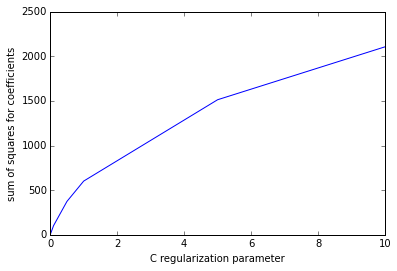

In [233]:
logistic_regression_hyperparameters = {'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0]}
logistic_regression_Cs = logistic_regression_hyperparameters['C']

def get_logistic_regression_coefs(train_data, train_labels, C):
    logistic_regression = LogisticRegression(C = C)
    logistic_regression.fit(train_data, train_labels)
    return logistic_regression.coef_

sum_of_coef_squares = [
    np.sum(get_logistic_regression_coefs(train_vectorized, train_labels, C) ** 2)
    for C in logistic_regression_Cs
]

print '***** (3) b. Naive Bayes and Logistic Regression *****'
print ''
plt.plot(logistic_regression_Cs, sum_of_coef_squares)
plt.xlabel('C regularization parameter')
plt.ylabel('sum of squares for coefficients')
_ = plt.show()

In [ ]:
logistic_regression = LogisticRegression(C = 0.5)
logistic_regression.fit(train_vectorized, train_labels)

logistic_regression.coef_

In [236]:
logistic_regression = LogisticRegression(C = 0.5)

In [237]:
logistic_regression.fit(train_vectorized, train_labels)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

In [238]:
logistic_regression.coef_

array([[ -9.05577031e-02,   2.81899821e-02,  -8.81065249e-06, ...,
         -1.18618257e-04,  -2.37236515e-04,  -8.39380776e-06],
       [  1.25339447e-01,   3.31150400e-02,  -4.89836837e-03, ...,
         -9.60600061e-04,  -1.92120012e-03,   1.42648095e-02],
       [ -5.93499619e-02,  -1.30402995e-01,   2.91311854e-03, ...,
          1.23729749e-03,   2.47459497e-03,  -1.08694131e-02],
       [ -8.05802508e-02,  -8.61766684e-03,  -6.86940659e-03, ...,
         -1.58798370e-04,  -3.17596740e-04,  -6.88253702e-06]])

In [263]:
N = 5
feature_names = vectorizer.get_feature_names()

def select_top_n_by_weight_indices(coefs, N):
    return np.array(coefs).argsort()[(-N):]

print '***** (4) selecting logistic features *****'
print ''
print '  Top 5 features by category:'

for index, category in enumerate(newsgroups_train.target_names):
    coefs = logistic_regression.coef_[index]
    top_n_indices = select_top_n_by_weight_indices(coefs, N)
    
    features = select_features(feature_names, top_n_indices)
    
    print '   Category ' + category + ': ' + str(features)
    
print ''

***** (4) selecting logistic features *****

  Top 5 features by category:
   Category alt.atheism: [u'atheism', u'atheists', u'bobby', u'deletion', u'religion']
   Category comp.graphics: [u'3d', u'computer', u'file', u'graphics', u'image']
   Category sci.space: [u'launch', u'nasa', u'orbit', u'space', u'spacecraft']
   Category talk.religion.misc: [u'blood', u'christian', u'christians', u'fbi', u'order']



In [296]:
import pandas as pd

top_feature_indices_by_category = [
    select_top_n_by_weight_indices(logistic_regression.coef_[category_index], N)
    for category_index 
    in range(len(newsgroups_train.target_names))   
]

top_feature_indices = np.sort(np.reshape(top_feature_indices_by_category, -1))
top_feature_names = select_features_by_indices(feature_names, top_feature_indices)
print(top_feature_indices)
print(top_feature_names)

weights_by_category = {
    category : logistic_regression.coef_[index][top_feature_indices]
    for index, category 
    in enumerate(newsgroups_train.target_names)
}

[ 1145  3866  3870  4743  4784  5901  5904  6555  7841 10234 10376 11552
 12769 14540 16697 17597 17609 20430 22567 22570]
[u'3d', u'atheism', u'atheists', u'blood', u'bobby', u'christian', u'christians', u'computer', u'deletion', u'fbi', u'file', u'graphics', u'image', u'launch', u'nasa', u'orbit', u'order', u'religion', u'space', u'spacecraft']


In [276]:
data_frame = pd.DataFrame(weights_by_category)

In [292]:
top_feature_indices = np.reshape(top_feature_indices, -1).sort()
top_feature_indices
#select_features(feature_names, top_feature_indices)

In [287]:
data_frame


,alt.atheism,comp.graphics,sci.space,talk.religion.misc
3d,0.723998,-0.249342,-0.272409,-0.270038
atheism,0.794833,-0.351204,-0.367056,-0.377134
atheists,0.798343,-0.508539,-0.658884,-0.050760
blood,0.823577,-0.191297,-0.286486,-0.387305
bobby,0.834500,-0.093333,-0.266974,-0.637608
christian,0.071378,0.844623,-0.569541,-0.396300
christians,-0.303420,0.941862,-0.571115,-0.317585
computer,-0.275313,1.059663,-0.682605,-0.506389
deletion,-0.469545,1.116957,-0.671895,-0.380328
fbi,-0.640874,1.626252,-1.103020,-0.626396


In [299]:
def vectorize_with_word_bigrams(data):
    vectorizer = CountVectorizer(ngram_range = (2, 2))
    vectorizer.fit(data)
    return vectorizer

bigram_vectorizer = vectorize_with_word_bigrams(train_data)
train_bigram_vectorized = bigram_vectorizer.transform(train_data)

In [300]:
np.shape(train_bigram_vectorized)

(2034, 194891)

In [301]:
    bigram_vectorizer = vectorize_with_word_bigrams(train_data)
    train_bigram_vectorized = bigram_vectorizer.transform(train_data)
    bigram_logistic_regression = LogisticRegression(C = 0.5)
    bigram_logistic_regression.fit(train_bigram_vectorized, train_labels)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

In [303]:
vectorizer = bigram_vectorizer
train_vectorized = train_bigram_vectorized
logistic_regression = bigram_logistic_regression

In [305]:
feature_names = vectorizer.get_feature_names()

In [307]:
top_feature_indices_by_category = [
            select_top_n_by_weight_indices(logistic_regression.coef_[category_index], N)
            for category_index 
            in range(len(newsgroups_train.target_names))   
        ]

In [310]:
top_feature_indices_by_category

[array([ 20596, 193317, 184771,  37174,  38326]),
 array([ 88596, 123709,  40451,  81950,  98723]),
 array([ 90070,  16732, 145068, 165984, 167336]),
 array([116318,  32640,  80535,  37174, 164806])]

In [319]:
top_feature_indices = np.unique(np.sort(np.reshape(top_feature_indices_by_category, -1)))

In [320]:
top_feature_indices

array([ 16732,  20596,  32640,  37174,  38326,  40451,  80535,  81950,
        88596,  90070,  98723, 116318, 123709, 145068, 164806, 165984,
       167336, 184771, 193317])

In [314]:
top_feature_names = select_features_by_indices(feature_names, top_feature_indices)

In [315]:
top_feature_names

[u'and such',
 u'are you',
 u'but he',
 u'cheers kent',
 u'claim that',
 u'comp graphics',
 u'ignorance is',
 u'in advance',
 u'is there',
 u'it was',
 u'looking for',
 u'of jesus',
 u'out there',
 u'sci space',
 u'the fbi',
 u'the moon',
 u'the space',
 u'was just',
 u'you are']

In [323]:
np.sort(np.reshape(top_feature_indices_by_category, -1))

array([ 16732,  20596,  32640,  37174,  37174,  38326,  40451,  80535,
        81950,  88596,  90070,  98723, 116318, 123709, 145068, 164806,
       165984, 167336, 184771, 193317])

In [326]:
feature_names[37174]

u'cheers kent'

In [343]:
def empty_preprocessor(s):
    return s

def vectorize_with_preprocessor(data, preprocessor = empty_preprocessor):
    vectorizer = CountVectorizer(preprocessor = preprocessor)
    vectorizer.fit(data)
    return vectorizer

def f_score_with_preprocessor(train_data, train_labels, dev_data, dev_labels, 
                              preprocessor = empty_preprocessor):
    
    
    vectorizer = vectorize_with_preprocessor(train_data, preprocessor)
    train_vectorized = vectorizer.transform(train_data)
    
    logistic_regression = LogisticRegression(C = 0.5)
    logistic_regression.fit(train_vectorized, train_labels)
    
    dev_vectorized = vectorizer.transform(dev_data)
    dev_predictions = logistic_regression.predict(dev_vectorized)
    
    f_score = metrics.f1_score(dev_labels, dev_predictions)
    
    return f_score

In [344]:
f_score_with_preprocessor(
    train_data, train_labels, dev_data, dev_labels,
    empty_preprocessor)
    

0.70691091854935018

In [334]:
baseline_vectorizer = vectorize_with_preprocessor(train_data)
baseline_train_vectorized = baseline_vectorizer.transform(train_data)

In [336]:
baseline_logistic_regression = LogisticRegression(C = 0.5)
baseline_logistic_regression.fit(baseline_train_vectorized, train_labels)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

In [338]:
baseline_dev_vectorized = baseline_vectorizer.transform(dev_data)
baseline_dev_predictions = baseline_logistic_regression.predict(baseline_dev_vectorized)
baseline_f1_score = metrics.f1_score(dev_labels, baseline_dev_predictions)

print 'Baseline f1 score: ' + str(baseline_f1_score)

Baseline f1 score: 0.708473977649


In [348]:
train_data[0:5]

[u"Hi,\n\nI've noticed that if you only save a model (with all your mapping planes\npositioned carefully) to a .3DS file that when you reload it after restarting\n3DS, they are given a default position and orientation.  But if you save\nto a .PRJ file their positions/orientation are preserved.  Does anyone\nknow why this information is not stored in the .3DS file?  Nothing is\nexplicitly said in the manual about saving texture rules in the .PRJ file. \nI'd like to be able to read the texture rule information, does anyone have \nthe format for the .PRJ file?\n\nIs the .CEL file format available from somewhere?\n\nRych",
 u'\n\nSeems to be, barring evidence to the contrary, that Koresh was simply\nanother deranged fanatic who thought it neccessary to take a whole bunch of\nfolks with him, children and all, to satisfy his delusional mania. Jim\nJones, circa 1993.\n\n\nNope - fruitcakes like Koresh have been demonstrating such evil corruption\nfor centuries.',
 u"\n >In article <1993Apr19.

In [370]:
def preprocessor_v1(s):
    s = s.lower() # lowercase the string
    s = re.sub(r"[^a-z']+", " ", s) # replace all non-alpha/apostrophe characters with a single space
    s = re.sub(r"(^|\s)'+", " ", s) # replace leading apostrophes with a single space
    s = re.sub(r"'+($|\s)", " ", s) # replace trailing apostrophes with a single space
    s = re.sub("the", " ", s) # throw out all the's
    s = re.sub(r"[\s]+", " ", s) # replace all white space with single space 
    return s
preprocessor = preprocessor_v1

preprocessor(train_data[0])

u"hi i've noticed that if you only save a model with all your mapping planes positioned carefully to a ds file that when you reload it after restarting ds y are given a default position and orientation but if you save to a prj file ir positions orientation are preserved does anyone know why this information is not stored in ds file nothing is explicitly said in manual about saving texture rules in prj file i'd like to be able to read texture rule information does anyone have format for prj file is cel file format available from somewhere rych"

In [368]:
preprocessor("Here's a quote 'something' 'something else' ''foo''.")

"here's a quote something something else foo "

In [379]:
#baseline
f_score_with_preprocessor(
    train_data, train_labels, dev_data, dev_labels,
    empty_preprocessor)

0.70691091854935018

In [428]:
def preprocessor_v2(s):
    s = s.lower() # lowercase the string
    s = re.sub(r"[^a-z0-9]+", " ", s) # replace all non-alphanumeric characters with a single space
    s = re.sub(r"[\s]+", " ", s) # replace all white space with single space
    s = re.sub(r" [a-z0-9]{1,3} ", " ", s) # throw out the short words between 1 and 3 characters
    s = re.sub(r"[0-9]+", "N", s) # replace all numbers with N
    s = re.sub(r"[aeo]", "", s) # discard all a, e, and o (i's turn out to be important)   
    return s

print(f_score_with_preprocessor(
    train_data, train_labels, dev_data, dev_labels,
    preprocessor = preprocessor_v2))

print([
        preprocessor_v2(s)
        for s 
        in train_data[30:40]
        ])



0.722153661284
[u' ctully thism bsd ignrnc ignrnc th xistnc ny dn fll int thists t bliv bcus thir prid mistk buchin bbb vic tk thy sid tht quns culd sty thy blw brnx wy snk mnhttn t ', u' might sur yu wuld ls wrng ', u' pckg bsd svrl rticls but stndrd rdisity sm unpublishd mthds min rticls chn chn wllc grnbrg prgrssiv rfinmnt pprch fst rdisity img gnrtin cmputr grphics siggrph N N N ugust N silin puch gnrl pss mthd intgrting spculr diffus rflctin cmputr grphics siggrph n ppN july N d us hmi cubs hv spcil hrdwr sprcsttin nnymus usrnm yur mil ddrss psswrd stphn stphn mnn cmputr grphics univrsity brn switzrlnd mnn unib tl N N fx N N prjcts rdisity rytrcing cmputr grphics ', u'srry missd rymnd ws just in dhlgrn lst mnth m virtul rlity mrkt mngr silicn grphics prhps cn hlp littl unfrtuntly whil systms wr usd crt spcil ffcts bth trmintr nd lwnmwr ths film qulity cmputr grphics rndrd sftwr writtn film frm  tim ch frm cmputr nimtin ths films tk hurs rndr high prlll prcssing cmputr systms thus 

 For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words.

In [355]:
train_data[0]

u"Hi,\n\nI've noticed that if you only save a model (with all your mapping planes\npositioned carefully) to a .3DS file that when you reload it after restarting\n3DS, they are given a default position and orientation.  But if you save\nto a .PRJ file their positions/orientation are preserved.  Does anyone\nknow why this information is not stored in the .3DS file?  Nothing is\nexplicitly said in the manual about saving texture rules in the .PRJ file. \nI'd like to be able to read the texture rule information, does anyone have \nthe format for the .PRJ file?\n\nIs the .CEL file format available from somewhere?\n\nRych"

In [430]:
vectorizer = vectorize_with_preprocessor(train_data, preprocessor)
len(vectorizer.get_feature_names())

23905